In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#### Q1.Read the data for January. How many columns are there?

In [51]:
df_jan = pd.read_parquet('yellow_tripdata_2023-01.parquet')
df_feb = pd.read_parquet('yellow_tripdata_2023-02.parquet')
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [52]:
df_jan.shape

(3066766, 19)

#### Answer: 19

#### Q2. Computing duration
###### What's the standard deviation of the trips duration in January?

In [53]:
df_jan.tpep_pickup_datetime = pd.to_datetime(df_jan.tpep_pickup_datetime)
df_jan.tpep_dropoff_datetime = pd.to_datetime(df_jan.tpep_dropoff_datetime)

In [54]:
df_jan['duration'] = df_jan.tpep_dropoff_datetime - df_jan.tpep_pickup_datetime

In [55]:
df_jan['duration'] = df_jan['duration'].apply(lambda val: val.total_seconds() / 60)

In [56]:
df_jan['duration'].std()

42.594351241920904

In [57]:
df_jan.duration

0           8.433333
1           6.316667
2          12.750000
3           9.616667
4          10.833333
             ...    
3066761    13.983333
3066762    19.450000
3066763    24.516667
3066764    13.000000
3066765    14.400000
Name: duration, Length: 3066766, dtype: float64

#### Answer B. 42.59

##### Q3. Dropping outliers
###### Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

###### What fraction of the records left after you dropped the outliers?

In [58]:
condition = (df_jan.duration >= 1.0) & (df_jan.duration <= 59.99)

In [59]:
df_jan = df_jan[condition]

In [60]:
df_jan.duration

0           8.433333
1           6.316667
2          12.750000
3           9.616667
4          10.833333
             ...    
3066761    13.983333
3066762    19.450000
3066763    24.516667
3066764    13.000000
3066765    14.400000
Name: duration, Length: 3009130, dtype: float64

In [61]:
(3009130/3066766)*100

98.12062609276352

##### Answer D: 98%

#### Q4. One-hot encoding
###### Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

###### Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
###### Fit a dictionary vectorizer
###### Get a feature matrix from it
###### What's the dimensionality of this matrix (number of columns)?

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [63]:
categorical = ['PULocationID','DOLocationID']

In [64]:
df_jan[categorical] = df_jan[categorical].astype(str)

In [65]:
train_dicts = df_jan[categorical].to_dict(orient='records') 

In [66]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [67]:
X_train

<3009130x515 sparse matrix of type '<class 'numpy.float64'>'
	with 6018260 stored elements in Compressed Sparse Row format>

##### Answer: 515

##### Q5. Training a model
###### Now let's use the feature matrix from the previous step to train a model.

###### Train a plain linear regression model with default parameters
###### Calculate the RMSE of the model on the training data
###### What's the RMSE on train?

In [68]:
target= 'duration'
y_train = df_jan[target].values

In [69]:
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [70]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [71]:
y_pred = lr.predict(X_train)

<Axes: ylabel='Count'>

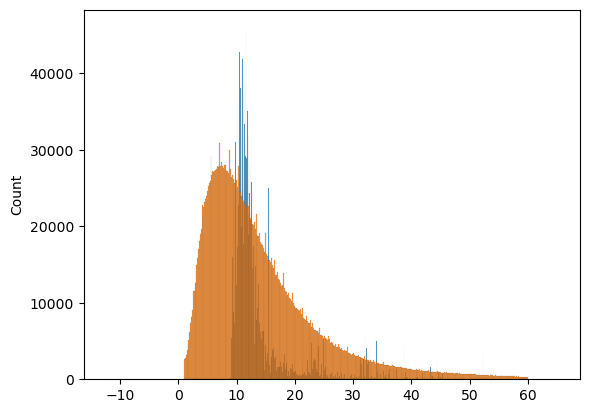

In [72]:
sns.histplot(y_pred,label='prediction')
sns.histplot(y_train,label='actual')

In [73]:
mean_squared_error(y_train, y_pred, squared=False)

7.648542473950659

##### Answer: 7.64

##### Q6. Evaluating the model
###### Now let's apply this model to the validation dataset (February 2023).

###### What's the RMSE on validation?

In [74]:
df_feb.tpep_pickup_datetime = pd.to_datetime(df_feb.tpep_pickup_datetime)
df_feb.tpep_dropoff_datetime = pd.to_datetime(df_feb.tpep_dropoff_datetime)

df_feb['duration'] = df_feb.tpep_dropoff_datetime - df_feb.tpep_pickup_datetime
df_feb['duration'] = df_feb['duration'].apply(lambda val: val.total_seconds() / 60)
df_feb['duration'].std()

df_feb = df_feb[condition]

In [75]:
df_feb[categorical] = df_feb[categorical].astype(str)

In [76]:
val_dicts = df_feb[categorical].to_dict(orient='records') 

In [77]:
val_train = dv.fit_transform(val_dicts)

In [78]:
y_val = df_feb[target].values

In [79]:
y_val

array([ 1.68333333,  0.23333333,  0.23333333, ..., 14.        ,
        7.        ,  9.8       ])

In [80]:
lr.fit(val_train, y_val)

LinearRegression()

In [81]:
val_pred = lr.predict(val_train)

In [82]:
mean_squared_error(y_val, val_pred, squared=False)

42.142190588960716